In this notebook, we will be generating features to use for Deep-PIPE-Sites.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import os
import json

In [2]:
masks_path = "data/yeast_masks_singlesite_filtered.pkl"
uniprot_file = "data/uniprot-proteome UP000002311.tab"# reference proteome at https://www.uniprot.org/proteomes/UP000002311
pssm_path = "data/yeast_pssms/"

processed_data_path = "data/yeast_processed_norm/"
PIPE_dir = "data/PIPE_output/landscapes/yeast-yeast/"

# Find the max and min values across entire set and naively normoalize it with the assumption that the domain of the set is the domain of all possible data
NORM = True
LOAD_PARAMS = True
load_params_path = processed_data_path + 'min_maxes.json'

# Load data and masks

## Load masks

In [3]:
ppi_masks = pd.read_pickle(masks_path)
ppi_masks.head()

,Uniprot ID A,Uniprot ID B,Domain_id_a,Domain_id_b,Domain positions A,Domain positions B,Sites Masks
0,P53081,P53081,[PF01784],[PF01784],"[(12, 275)]","[(12, 275)]","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
1,Q12188,P47037,[PF04825],[PF02463],"[(11, 136)]","[(2, 1208)]","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
2,Q03020,P25374,[PF01592],[PF00266],"[(34, 161)]","[(100, 462)]","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
3,P17065,P51996,[PF06428],[PF00071],"[(79, 170)]","[(15, 176)]","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
4,P00546,P20437,[PF00069],[PF00134],"[(8, 295)]","[(41, 193)]","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."


In [4]:
ppi_masks.shape

(1606, 7)

In [5]:
# All the protein sequences we need information for
proteins = ppi_masks['Uniprot ID A'].append(ppi_masks['Uniprot ID B'], ignore_index=True).unique()
proteins, proteins.shape

(array(['P53081', 'Q12188', 'Q03020', ..., 'P22219', 'P12612', 'P38080'],
       dtype=object),
 (1258,))

## Load sequences

In [6]:
uniprot_df = pd.read_csv(uniprot_file,
                        sep = "\t", index_col='Entry')
print("Loaded UniProt proteome")
uniprot_df

Loaded UniProt proteome


,Entry name,Status,Protein names,Gene names,Organism,Length,Sequence
Entry,,,,,,,
P21192,ACE2_YEAST,reviewed,Metallothionein expression activator,ACE2 YLR131C L3123 L9606.10,Saccharomyces cerevisiae (strain ATCC 204508 /...,770,MDNVVDPWYINPSGFAKDTQDEEYVQHHDNVNPTIPPPDNYILNNE...
P46993,ASG7_YEAST,reviewed,Protein ASG7 (A-specific gene 7 protein),ASG7 YJL170C J0514,Saccharomyces cerevisiae (strain ATCC 204508 /...,209,MTTLASSIEHKTKHLAAPFENDENPWMKKYCCQCKSCKMSVPVQPW...
P47117,ARP3_YEAST,reviewed,Actin-related protein 3 (Actin-like protein AR...,ARP3 ACT4 YJR065C J1760,Saccharomyces cerevisiae (strain ATCC 204508 /...,449,MSYLNNPAVVMDNGTGLTKLGFAGNDSPSWVFPTAIATAAPSNTKK...
P22768,ASSY_YEAST,reviewed,Argininosuccinate synthase (EC 6.3.4.5) (Citru...,ARG1 YOL058W O1228,Saccharomyces cerevisiae (strain ATCC 204508 /...,420,MSKGKVCLAYSGGLDTSVILAWLLDQGYEVVAFMANVGQEEDFDAA...
P29311,BMH1_YEAST,reviewed,Protein BMH1,BMH1 YER177W,Saccharomyces cerevisiae (strain ATCC 204508 /...,267,MSTSREDSVYLAKLAEQAERYEEMVENMKTVASSGQELSVEERNLL...
...,...,...,...,...,...,...,...
P47049,UBX6_YEAST,reviewed,UBX domain-containing protein 6,UBX6 YJL048C J1164,Saccharomyces cerevisiae (strain ATCC 204508 /...,396,MYEMSGIDSLFHDRVVHDYSHTSEQVIVVYISSAAGDNSWLHQWFK...
P53142,VPS73_YEAST,reviewed,Vacuolar protein sorting-associated protein 73,VPS73 YGL104C G3090,Saccharomyces cerevisiae (strain ATCC 204508 /...,486,MNRILSSASLLSNVSMPRQNKHKITKALCYAIIVASIGSIQFGYHL...
Q05919,VPS38_YEAST,reviewed,Vacuolar protein sorting-associated protein 38,VPS38 VPL17 YLR360W L8039.11,Saccharomyces cerevisiae (strain ATCC 204508 /...,439,MKRFLLSRRQRHLRMICFHNISLFRANGDSKLIKEYGDGFIPCFFI...


Create naive storage of min/max values for normalization

In [8]:
if NORM:
    if LOAD_PARAMS:
        with open(load_params_path, 'r') as f:
            min_maxes = json.load(f)
    else:
        min_maxes = {}
    
def update_min_max(min_val, max_val, mask):
    if np.max(mask) > max_val:
        max_val = np.max(mask)
    if np.min(mask) < min_val:
        min_val = np.min(mask)
        
    return min_val, max_val

def norm(min_val, max_val, mask_list):
    return [(mat - min_val) / (max_val - min_val) for mat in mask_list]

## ProtDCal

Generated using https://protdcal.zmb.uni-due.de/pages/form.php

## PSSMs

psiblast -query 'uniprot-proteome UP000002311.fasta' -db ~/sysc4906/s/swissprot -inclusion_ethresh 0.001 -num_iterations 2 -out_ascii_pssm yeast_filtered.pssm -save_pssm_after_last_round

/home/wma/sysc4906/ncbi-blast-2.11.0+/bin

for file in *.fasta; do echo "./runPsiBlast.sh '$file'"; done >> blastall.sh

rename -n 's/sp\|(.*?)\|.*/$1.pssm/' *

In [9]:
# psiblast -query .\output_sequences.fasta -db nr -out yeast_filtered_psiblast_out -evalue 0.001 -num_iterations 3 -out_pssm yeast_filtered_pssm_checkpoint -out_ascii_pssm yeast_filtered_pssm

In [10]:
AA = ['A', 'R', 'N', 'D', 'C', 'Q', 'E', 'G', 'H', 'I', 'L', 'K', 'M', 'F', 'P', 'S', 'T', 'W', 'Y', 'V']

In [11]:
print("Loading PSSMs")
PSSMs = {}
for swissprot_id in proteins:
    pssm_A = pd.read_csv(pssm_path + swissprot_id + ".pssm", sep = "\s+", skiprows=2).reset_index()[AA].dropna()
    PSSMs[swissprot_id] = pssm_A.to_numpy()

Loading PSSMs


In [12]:
PSSM_masks = []

if NORM and not LOAD_PARAMS:
    max_val = np.NINF
    min_val = np.inf
print("Generating PSSM masks")
for UA, UB, SM in zip(ppi_masks['Uniprot ID A'], ppi_masks['Uniprot ID B'], ppi_masks['Sites Masks']):
    try:        
        # number according to position    
        seqA = PSSMs[UA]
        seqB = PSSMs[UB]
        
        
        # Do a dot product for each 20 length vector along each position
        mask = np.matmul(seqA, seqB.T)
        
        assert SM.shape == mask.shape
        
        if NORM and not LOAD_PARAMS:
            min_val, max_val = update_min_max(min_val, max_val, mask)
            
        PSSM_masks.append(mask)
    except KeyError as inst:
        print(UA, UB)
        print(f"No uniprot entry found for protein {inst.args}")
        position_landscape.append(np.NaN)

Generating PSSM masks


In [13]:
# np.set_printoptions(threshold=1000)
PSSM_masks[:10]

[array([[118., -11., -15., ...,  -3.,  89.,  18.],
        [-11., 550.,  59., ...,  47.,   3.,  34.],
        [-15.,  59., 399., ..., 172., -11.,  28.],
        ...,
        [ -3.,  47., 172., ..., 138., -11.,  17.],
        [ 89.,   3., -11., ..., -11., 122.,  33.],
        [ 18.,  34.,  28., ...,  17.,  33.,  32.]]),
 array([[174.,  68., 113., ...,  14., -17.,  60.],
        [ 84.,   9.,  73., ...,  38.,  18.,  33.],
        [ 80.,   4., 120., ...,  45.,  57.,  18.],
        ...,
        [172.,  49., 179., ...,  32., -15.,  92.],
        [ 57., 116.,  41., ...,  -8., -17.,  16.],
        [ 84.,   9.,  73., ...,  38.,  18.,  33.]]),
 array([[ 81.,  82.,   6., ..., -10., -19.,  -8.],
        [ 87., 117.,   9., ...,  -4., -22.,  -3.],
        [ -4.,   7.,  52., ...,  34.,  33.,  42.],
        ...,
        [ 80., 101.,   1., ...,  -1., -26., -19.],
        [ 93., 129.,   3., ...,  -9., -23.,  -3.],
        [-10., -18.,  37., ...,  47.,  31.,  24.]]),
 array([[ 1.140e+02, -7.000e+00, -2.7

In [14]:
if NORM:
    if LOAD_PARAMS:
        PSSM_masks = norm(min_maxes['PSSM'][0], min_maxes['PSSM'][1], PSSM_masks)
    else:
        PSSM_masks = norm(min_val, max_val, PSSM_masks)
        min_maxes['PSSM'] = (min_val, max_val)
        
    print(PSSM_masks[:10])

[array([[0.02794896, 0.01675202, 0.01640483, ..., 0.0174464 , 0.02543182,
        0.01926916],
       [0.01675202, 0.06544571, 0.02282788, ..., 0.0217863 , 0.01796719,
        0.02065793],
       [0.01640483, 0.02282788, 0.05233921, ..., 0.03263606, 0.01675202,
        0.02013714],
       ...,
       [0.0174464 , 0.0217863 , 0.03263606, ..., 0.02968492, 0.01675202,
        0.01918236],
       [0.02543182, 0.01796719, 0.01675202, ..., 0.01675202, 0.02829615,
        0.02057113],
       [0.01926916, 0.02065793, 0.02013714, ..., 0.01918236, 0.02057113,
        0.02048433]]), array([[0.03280965, 0.02360906, 0.02751497, ..., 0.01892197, 0.01623123,
        0.02291468],
       [0.02499783, 0.01848798, 0.02404305, ..., 0.02100512, 0.01926916,
        0.02057113],
       [0.02465064, 0.01805399, 0.02812256, ..., 0.02161271, 0.02265428,
        0.01926916],
       ...,
       [0.03263606, 0.0219599 , 0.03324364, ..., 0.02048433, 0.01640483,
        0.02569221],
       [0.02265428, 0.02777537, 0

In [15]:
ppi_masks['PSSM_masks'] = PSSM_masks
ppi_masks

,Uniprot ID A,Uniprot ID B,Domain_id_a,Domain_id_b,Domain positions A,Domain positions B,Sites Masks,PSSM_masks
0,P53081,P53081,[PF01784],[PF01784],"[(12, 275)]","[(12, 275)]","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0.02794896276364899, 0.01675201805398837, 0...."
1,Q12188,P47037,[PF04825],[PF02463],"[(11, 136)]","[(2, 1208)]","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0.03280965193993577, 0.023609061713392936, 0..."
2,Q03020,P25374,[PF01592],[PF00266],"[(34, 161)]","[(100, 462)]","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0.02473743598645951, 0.02482423400746463, 0...."
3,P17065,P51996,[PF06428],[PF00071],"[(79, 170)]","[(15, 176)]","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0.027601770679628504, 0.017099210138008854, ..."
4,P00546,P20437,[PF00069],[PF00134],"[(8, 295)]","[(41, 193)]","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0.03194167172988456, 0.014234875444839857, 0..."
...,...,...,...,...,...,...,...,...
1601,Q12403,P54837,[PF01105],[PF01105],"[(23, 218)]","[(20, 206)]","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0.030552903393802622, 0.01918236264213176, 0..."
1602,Q06549,Q06549,[PF00383],[PF00383],"[(8, 115)]","[(8, 115)]","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0.02734137661661314, 0.01597083586494228, 0...."
1603,Q12335,Q12335,[PF03358],[PF03358],"[(8, 148)]","[(8, 148)]","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0.03558718861209965, 0.01926916066313688, 0...."
1604,P53725,P38792,[PF10175],[PF15985],"[(9, 186)]","[(197, 239)]","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0.023869455776408297, 0.01683881607499349, 0..."


In [16]:
# clear from memory
del PSSM_masks

## Position

In [42]:
position_landscape = []
print("Generating position feature landscape")
for UA, UB, SM in zip(ppi_masks['Uniprot ID A'], ppi_masks['Uniprot ID B'], ppi_masks['Sites Masks']):
    try:
        lengths = (uniprot_df['Length'].loc[UA], uniprot_df['Length'].loc[UB])
        
        # number according to position    
        seqA = np.arange(1, lengths[0]+1)[np.newaxis]
        seqB = np.arange(1, lengths[1]+1)[np.newaxis]
        
        # normalize
        seqA = np.divide(seqA, lengths[0])
        seqB = np.divide(seqB, lengths[1])
        
        mask = np.matmul(seqA.T, seqB)
        
        assert SM.shape == mask.shape
        
        position_landscape.append(mask)
    except KeyError as inst:
        print(UA, UB)
        print(f"No uniprot entry found for protein {inst.args}")
        position_landscape.append(np.NaN)
        
position_landscape = np.asarray(position_landscape)
print(lengths, mask.shape)

Generating position feature landscape
(191, 202) (191, 202)


C:\Users\mawil\Anaconda3\envs\SYSC4907\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


In [18]:
position_landscape[:2]

array([array([[1.20563272e-05, 2.41126543e-05, 3.61689815e-05, ...,
        3.44810957e-03, 3.46016590e-03, 3.47222222e-03],
       [2.41126543e-05, 4.82253086e-05, 7.23379630e-05, ...,
        6.89621914e-03, 6.92033179e-03, 6.94444444e-03],
       [3.61689815e-05, 7.23379630e-05, 1.08506944e-04, ...,
        1.03443287e-02, 1.03804977e-02, 1.04166667e-02],
       ...,
       [3.44810957e-03, 6.89621914e-03, 1.03443287e-02, ...,
        9.86159336e-01, 9.89607446e-01, 9.93055556e-01],
       [3.46016590e-03, 6.92033179e-03, 1.03804977e-02, ...,
        9.89607446e-01, 9.93067612e-01, 9.96527778e-01],
       [3.47222222e-03, 6.94444444e-03, 1.04166667e-02, ...,
        9.93055556e-01, 9.96527778e-01, 1.00000000e+00]]),
       array([[1.19560019e-06, 2.39120038e-06, 3.58680057e-06, ...,
        1.46819703e-03, 1.46939264e-03, 1.47058824e-03],
       [2.39120038e-06, 4.78240077e-06, 7.17360115e-06, ...,
        2.93639407e-03, 2.93878527e-03, 2.94117647e-03],
       [3.58680057e-06, 7.17

In [19]:
# # The data are already normalized from 0 to 1
# if NORM:
#     min_maxes['Position'] = (0,1)

In [20]:
ppi_masks['position_landscape'] = position_landscape
ppi_masks

,Uniprot ID A,Uniprot ID B,Domain_id_a,Domain_id_b,Domain positions A,Domain positions B,Sites Masks,PSSM_masks,position_landscape
0,P53081,P53081,[PF01784],[PF01784],"[(12, 275)]","[(12, 275)]","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0.02794896276364899, 0.01675201805398837, 0....","[[1.2056327160493826e-05, 2.4112654320987653e-..."
1,Q12188,P47037,[PF04825],[PF02463],"[(11, 136)]","[(2, 1208)]","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0.03280965193993577, 0.023609061713392936, 0...","[[1.1956001912960306e-06, 2.391200382592061e-0..."
2,Q03020,P25374,[PF01592],[PF00266],"[(34, 161)]","[(100, 462)]","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0.02473743598645951, 0.02482423400746463, 0....","[[1.2194378391561491e-05, 2.4388756783122982e-..."
3,P17065,P51996,[PF06428],[PF00071],"[(79, 170)]","[(15, 176)]","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0.027601770679628504, 0.017099210138008854, ...","[[5.934788543484196e-06, 1.1869577086968392e-0..."
4,P00546,P20437,[PF00069],[PF00134],"[(8, 295)]","[(41, 193)]","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0.03194167172988456, 0.014234875444839857, 0...","[[6.145979300341716e-06, 1.2291958600683432e-0..."
...,...,...,...,...,...,...,...,...,...
1601,Q12403,P54837,[PF01105],[PF01105],"[(23, 218)]","[(20, 206)]","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0.030552903393802622, 0.01918236264213176, 0...","[[2.1063717746182202e-05, 4.2127435492364404e-..."
1602,Q06549,Q06549,[PF00383],[PF00383],"[(8, 115)]","[(8, 115)]","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0.02734137661661314, 0.01597083586494228, 0....","[[4.959333465582226e-05, 9.918666931164451e-05..."
1603,Q12335,Q12335,[PF03358],[PF03358],"[(8, 148)]","[(8, 148)]","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0.03558718861209965, 0.01926916066313688, 0....","[[2.5507601265177026e-05, 5.101520253035405e-0..."
1604,P53725,P38792,[PF10175],[PF15985],"[(9, 186)]","[(197, 239)]","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0.023869455776408297, 0.01683881607499349, 0...","[[1.4975888819001409e-05, 2.9951777638002818e-..."


In [21]:
# free from memory
del position_landscape

## PIPE

In [22]:
# Pandas is a little faster at file access and parsing than using Python

# import time

# PIPE_landscape = []
# PIPE_landscape_SW = []
# start = time.time()
# for protA, protB in zip(ppi_masks['Uniprot ID A'], ppi_masks['Uniprot ID B']):
#     PIPE_landscape_name = protA + '-' + protB
    
#     # load PIPE landscape
#     with open(PIPE_dir + PIPE_landscape_name + '.mat', 'r') as PIPE_file:
#         pipe_lines = PIPE_file.readlines()
    
#     # Last row and column is a sum, we don't need that
#     # get rid of \n too
#     landscape = np.zeros((len(pipe_lines)-1, len(pipe_lines[0].split(' '))-2), dtype=np.float)
#     for j in range(len(pipe_lines)-1):
#         line = np.array(pipe_lines[j].split(' ')[:-2]) # last two are sum, \n respectively
#         line = line.astype(np.float)
        
#         landscape[j] = line
        
#     PIPE_landscape.append(landscape)
    
#     # load PIPE landscape, sw score adjusted
#     with open(PIPE_dir + PIPE_landscape_name + '_SW.mat', 'r') as PIPE_file:
#         pipe_lines = PIPE_file.readlines()
    
#     # Last row and column is a sum, we don't need that
#     # get rid of \n too
#     landscape = np.zeros((len(pipe_lines)-1, len(pipe_lines[0].split(' '))-2), dtype=np.float)
#     for j in range(len(pipe_lines)-1):
#         line = np.array(pipe_lines[j].split(' ')[:-2]) # last two are sum, \n respectively
#         line = line.astype(np.float)
        
#         landscape[j] = line
        
#     PIPE_landscape_SW.append(landscape)
    
# end = time.time()
    
# PIPE_landscape[89].shape, PIPE_landscape_SW[89].shape, ppi_masks.PSSM_masks.iloc[89].shape, end-start       

In [23]:
# import time
W = 20 # PIPE window size, PIPE matrix is smaller than protein sequence by W-1
pad = ((W-1) // 2, (W-1) - (W-1) //2)

if NORM and not LOAD_PARAMS:
    max_val = np.NINF
    min_val = np.inf
    max_val_sw = np.NINF
    min_val_sw = np.inf    
    
PIPE_landscape = []
PIPE_landscape_SW = []
# start = time.time()
for protA, protB in zip(ppi_masks['Uniprot ID A'], ppi_masks['Uniprot ID B']):
    PIPE_landscape_name = protA + '-' + protB
    
    # load landscape
    landscape_df = pd.read_csv(PIPE_dir + PIPE_landscape_name + '.mat',
                               delim_whitespace=True,
                               header=None,
                               index_col=None)
    landscape = landscape_df.to_numpy().astype(np.float)
    landscape = np.pad(landscape[:-1, :-1], (pad, pad), 'minimum') # last row/column is a sum
    
    if NORM and not LOAD_PARAMS:
        min_val, max_val = update_min_max(min_val, max_val, landscape)
    
    PIPE_landscape.append(landscape) 
    
    # load sw landscape
    landscape_df = pd.read_csv(PIPE_dir + PIPE_landscape_name + '_SW.mat',
                               delim_whitespace=True,
                               header=None,
                               index_col=None)
    landscape = landscape_df.to_numpy().astype(np.float)
    landscape = np.pad(landscape[:-1, :-1], (pad, pad), 'minimum') # last row/column is a sum
    
    if NORM and not LOAD_PARAMS:
        min_val_sw, max_val_sw = update_min_max(min_val_sw, max_val_sw, landscape)
            
    PIPE_landscape_SW.append(landscape) # last row/column is a sum

# end = time.time()
PIPE_landscape[89].shape, PIPE_landscape_SW[89].shape, ppi_masks.PSSM_masks.iloc[89].shape #, end-start


((148, 587), (148, 587), (148, 587))

In [24]:
if NORM:
    if LOAD_PARAMS:
        PIPE_landscape = norm(min_maxes['PIPE'][0],  min_maxes['PIPE'][1], PIPE_landscape)
        PIPE_landscape_SW = norm(min_maxes['PIPE_sw'][0], min_maxes['PIPE_sw'][1], PIPE_landscape_SW)
    else:
        PIPE_landscape = norm(min_val, max_val, PIPE_landscape)
        PIPE_landscape_SW = norm(min_val_sw, max_val_sw, PIPE_landscape_SW)

        min_maxes['PIPE'] = (min_val, max_val)    
        min_maxes['PIPE_sw'] = (min_val_sw, max_val_sw)
    
    print(PIPE_landscape[:2])
    print(PIPE_landscape_SW[:2])

[array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]]), array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])]
[array([[0.00904329, 0.00904329, 0.00904329, ..., 0.00904329, 0.00904329,
        0.00904329],
       [0.00904329, 0.00904329, 0.00904329, ..., 0.00904329, 0.00904329,
        0.00904329],
       [0.00904329, 0.00904329, 0.00904329, ..., 0.00904329, 0.00904329,
        0.00904329],
       ...,
       [0.00904329, 0.00904329, 0.00904329, ..., 0.00904329, 0.00904329,
        0.00904329],
       [0.00904329, 0.00904329, 0.00904329, ..., 0.00904329, 0.00904329,
        0.00904329],
       [0.00904329, 0.00904329, 

In [25]:
ppi_masks['PIPE_landscape'] = PIPE_landscape
ppi_masks['PIPE_landscape_SW'] = PIPE_landscape_SW
ppi_masks

,Uniprot ID A,Uniprot ID B,Domain_id_a,Domain_id_b,Domain positions A,Domain positions B,Sites Masks,PSSM_masks,position_landscape,PIPE_landscape,PIPE_landscape_SW
0,P53081,P53081,[PF01784],[PF01784],"[(12, 275)]","[(12, 275)]","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0.02794896276364899, 0.01675201805398837, 0....","[[1.2056327160493826e-05, 2.4112654320987653e-...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.009043294521258452, 0.009043294521258452, ..."
1,Q12188,P47037,[PF04825],[PF02463],"[(11, 136)]","[(2, 1208)]","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0.03280965193993577, 0.023609061713392936, 0...","[[1.1956001912960306e-06, 2.391200382592061e-0...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.00035896824806535123, 0.000358968248065351..."
2,Q03020,P25374,[PF01592],[PF00266],"[(34, 161)]","[(100, 462)]","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0.02473743598645951, 0.02482423400746463, 0....","[[1.2194378391561491e-05, 2.4388756783122982e-...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.006125085304223783, 0.006125085304223783, ..."
3,P17065,P51996,[PF06428],[PF00071],"[(79, 170)]","[(15, 176)]","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0.027601770679628504, 0.017099210138008854, ...","[[5.934788543484196e-06, 1.1869577086968392e-0...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.00048163514208694204, 0.000481635142086942..."
4,P00546,P20437,[PF00069],[PF00134],"[(8, 295)]","[(41, 193)]","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0.03194167172988456, 0.014234875444839857, 0...","[[6.145979300341716e-06, 1.2291958600683432e-0...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0011202288258748544, 0.0011202288258748544..."
...,...,...,...,...,...,...,...,...,...,...,...
1601,Q12403,P54837,[PF01105],[PF01105],"[(23, 218)]","[(20, 206)]","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0.030552903393802622, 0.01918236264213176, 0...","[[2.1063717746182202e-05, 4.2127435492364404e-...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.005904615710880292, 0.005904615710880292, ..."
1602,Q06549,Q06549,[PF00383],[PF00383],"[(8, 115)]","[(8, 115)]","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0.02734137661661314, 0.01597083586494228, 0....","[[4.959333465582226e-05, 9.918666931164451e-05...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.008216808809446485, 0.008216808809446485, ..."
1603,Q12335,Q12335,[PF03358],[PF03358],"[(8, 148)]","[(8, 148)]","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0.03558718861209965, 0.01926916066313688, 0....","[[2.5507601265177026e-05, 5.101520253035405e-0...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.022175238498034593, 0.022175238498034593, ..."
1604,P53725,P38792,[PF10175],[PF15985],"[(9, 186)]","[(197, 239)]","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0.023869455776408297, 0.01683881607499349, 0...","[[1.4975888819001409e-05, 2.9951777638002818e-...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0008822263900958177, 0.0008822263900958177..."


In [26]:
del PIPE_landscape
del PIPE_landscape_SW

## Prot2Vec

In [27]:
ppi_masks.iloc[839]

Uniprot ID A                                                     P14681
Uniprot ID B                                                     P23561
Domain_id_a                                                   [PF00069]
Domain_id_b                                                   [PF00069]
Domain positions A                                          [(13, 313)]
Domain positions B                                         [(473, 712)]
Sites Masks           [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...
PSSM_masks            [[0.030813297456817986, 0.015623643780921796, ...
position_landscape    [[3.789946031168516e-06, 7.579892062337032e-06...
PIPE_landscape        [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...
PIPE_landscape_SW     [[0.00020876603099902346, 0.000208766030999023...
Name: 839, dtype: object

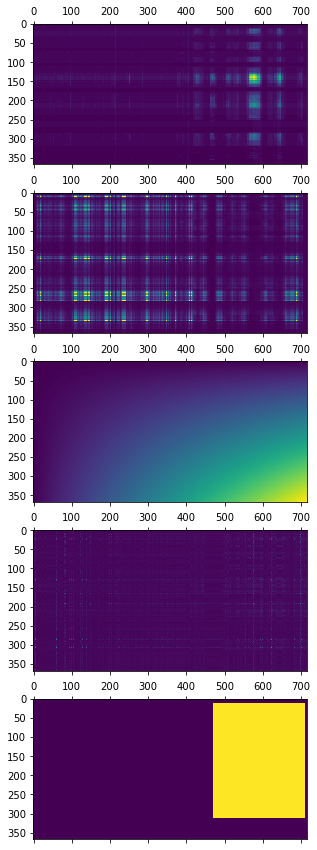

In [60]:
import matplotlib.pyplot as plt
query=839
fig, axs = plt.subplots(5, figsize=(15,15))
axs[0].matshow(ppi_masks.PIPE_landscape.iloc[query])
axs[1].matshow(ppi_masks.PIPE_landscape_SW.iloc[query])
axs[2].matshow(ppi_masks.position_landscape.iloc[query])
axs[3].matshow(ppi_masks.PSSM_masks.iloc[query])
axs[4].matshow(ppi_masks['Sites Masks'].iloc[query])
plt.show()

# Save

In [32]:
if not os.path.isdir(processed_data_path):
    os.mkdir(processed_data_path)

if NORM and not LOAD_PARAMS:
    print(min_maxes)
    
    with open(processed_data_path + 'min_maxes.json','w') as f:
        json.dump(min_maxes,f)

{'PSSM': (-204.0, 11317.0), 'PIPE': (1.0, 696.0), 'PIPE_sw': (0.048049, 1000.0)}


In [33]:
ppi_masks.to_pickle(processed_data_path + 'data_processed_2021-01-04.pkl')

In [34]:
from sklearn.model_selection import train_test_split
train_df, test_df = train_test_split(ppi_masks, test_size=0.1, random_state=86)

In [35]:

# for UA, UB, site_mask, PSSM_mask, position_landscape in zip(ppi_masks['Uniprot ID A'], ppi_masks['Uniprot ID B'], ppi_masks['Sites Masks'], ppi_masks['PSSM_masks'], ppi_masks['position_landscape']):
#     features = np.stack([PSSM_mask, position_landscape])
#     np.save(f'{processed_data_path}masks/{UA}_{UB}.npy', site_mask)
#     np.save(f'{processed_data_path}features/{UA}_{UB}.npy', features)


In [36]:
train_df

,Uniprot ID A,Uniprot ID B,Domain_id_a,Domain_id_b,Domain positions A,Domain positions B,Sites Masks,PSSM_masks,position_landscape,PIPE_landscape,PIPE_landscape_SW
572,P39958,P07560,[PF00996],[PF00071],"[(1, 447)]","[(22, 182)]","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0.02629980036455169, 0.018053988369065185, 0...","[[1.031299953591502e-05, 2.062599907183004e-05...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.005080400108144797, 0.005080400108144797, ..."
789,P53236,P61830,[PF01426],[PF00125],"[(368, 486)]","[(1, 132)]","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0.029858519225761652, 0.019789948789167608, ...","[[7.92342799188641e-06, 1.584685598377282e-05,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.005194135573020148, 0.005194135573020148, ..."
1355,P53076,P38263,[PF00622],[PF09783],"[(401, 590)]","[(122, 347)]","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0.023869455776408297, 0.023695859734398056, ...","[[2.883539602532901e-06, 5.767079205065802e-06...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[1.3321640091484762e-05, 1.3321640091484762e-..."
1600,P05626,P07251,[PF05405],[PF02874],"[(75, 237)]","[(62, 129)]","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0.024650637965454386, 0.022654283482336602, ...","[[7.519927808693037e-06, 1.5039855617386074e-0...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.003285441862196037, 0.003285441862196037, ..."
262,P47122,Q06543,[PF03029],[PF03029],"[(8, 258)]","[(8, 255)]","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0.030813297456817986, 0.016318027948962765, ...","[[9.549274255156608e-06, 1.9098548510313215e-0...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0013033646253668841, 0.0013033646253668841..."
...,...,...,...,...,...,...,...,...,...,...,...
1001,Q03790,Q03790,[PF05172],[PF05172],"[(239, 357)]","[(239, 357)]","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0.025084628070479995, 0.019789948789167608, ...","[[4.432132963988919e-06, 8.864265927977838e-06...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.00012133382996919618, 0.000121333829969196..."
27,P33332,P32855,[PF09763],[PF04048],"[(640, 1316)]","[(34, 175)]","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0.023695859734398056, 0.015102855654891069, ...","[[7.028197126873015e-07, 1.405639425374603e-06...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0003771391211576325, 0.0003771391211576325..."
1123,P40568,P39731,[PF08202],[PF05859],"[(223, 572)]","[(11, 146)]","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0.023695859734398056, 0.01683881607499349, 0...","[[6.007304882737409e-06, 1.2014609765474818e-0...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0003787721996254198, 0.0003787721996254198..."
1452,P10622,P02400,[PF00428],[PF00428],"[(19, 105)]","[(17, 109)]","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0.0288169429737002, 0.017967190348060064, 0....","[[8.576329331046312e-05, 0.0001715265866209262...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.00037598506570642214, 0.000375985065706422..."


In [37]:
test_df

,Uniprot ID A,Uniprot ID B,Domain_id_a,Domain_id_b,Domain positions A,Domain positions B,Sites Masks,PSSM_masks,position_landscape,PIPE_landscape,PIPE_landscape_SW
1482,P38779,P14120,[PF00687],[PF01248],"[(44, 287)]","[(8, 102)]","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0.025258224112490235, 0.01926916066313688, 0...","[[2.5329280648429586e-05, 5.065856129685917e-0...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0024773230328944073, 0.0024773230328944073..."
811,P32325,P32562,[PF07535],[PF00069],"[(656, 700)]","[(82, 337)]","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0.02491103202846975, 0.017099210138008854, 0...","[[2.014829142488717e-06, 4.029658284977434e-06...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.000641636830008045, 0.000641636830008045, ..."
235,P87108,P32830,[PF02953],[PF02953],"[(18, 82)]","[(21, 83)]","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0.0288169429737002, 0.0160576338859474, 0.02...","[[9.864851533984414e-05, 0.0001972970306796883...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.011857282730577921, 0.011857282730577921, ..."
155,P24279,P40359,[PF00493],[PF05916],"[(346, 569)]","[(69, 178)]","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0.02699418453259266, 0.01918236264213176, 0....","[[4.835052194388438e-06, 9.670104388776876e-06...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0003355501228478527, 0.0003355501228478527..."
1460,P19263,Q06213,[PF08638],[PF09748],"[(89, 292)]","[(19, 142)]","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0.024563839944449266, 0.01701241211700373, 0...","[[5.886716036591827e-06, 1.1773432073183654e-0...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0010389579208891408, 0.0010389579208891408..."
...,...,...,...,...,...,...,...,...,...,...,...
1370,Q08649,P38806,[PF01853],[PF12998],"[(223, 400)]","[(6, 111)]","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0.028382952868674594, 0.015797239822932036, ...","[[7.96876245119133e-06, 1.593752490238266e-05,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.002516174899687755, 0.002516174899687755, ..."
49,P22082,Q12406,[PF00176],[PF00022],"[(769, 1065)]","[(2, 467)]","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0.028209356826664353, 0.016404825969967885, ...","[[1.2310252840283087e-06, 2.4620505680566173e-...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0002549932521707736, 0.0002549932521707736..."
437,P11076,P41810,[PF00025],[PF01602],"[(5, 177)]","[(20, 560)]","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0.03280965193993577, 0.02005034285218297, 0....","[[5.678172536950708e-06, 1.1356345073901415e-0...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0011942443822483227, 0.0011942443822483227..."
66,P00427,P04037,[PF02284],[PF01215],"[(45, 145)]","[(27, 155)]","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0.024650637965454386, 0.025084628070479995, ...","[[4.359197907585005e-05, 8.71839581517001e-05,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.005243207930897872, 0.005243207930897872, ..."


In [40]:
if not os.path.isdir(processed_data_path + 'train/'):
    os.mkdir(processed_data_path + 'train/')
if not os.path.isdir(processed_data_path + 'test/'):
    os.mkdir(processed_data_path + 'test/')

if not os.path.isdir(processed_data_path + 'train/masks/'):
    os.mkdir(processed_data_path + 'train/masks/')
if not os.path.isdir(processed_data_path + 'test/masks/'):
    os.mkdir(processed_data_path + 'test/masks/')
if not os.path.isdir(processed_data_path + 'train/features/'):
    os.mkdir(processed_data_path + 'train/features/')
if not os.path.isdir(processed_data_path + 'test/features/'):
    os.mkdir(processed_data_path + 'test/features/')


for UA, UB, site_mask, PSSM_mask, position_landscape, PIPE_landscape,  PIPE_landscape_SW in zip(test_df['Uniprot ID A'], 
                                                                                                test_df['Uniprot ID B'], 
                                                                                                test_df['Sites Masks'], 
                                                                                                test_df['PSSM_masks'], 
                                                                                                test_df['position_landscape'],
                                                                                                test_df['PIPE_landscape'],
                                                                                                test_df['PIPE_landscape_SW']):
    features = np.stack([PSSM_mask, position_landscape, PIPE_landscape,  PIPE_landscape_SW])
    np.save(f'{processed_data_path}test/masks/{UA}_{UB}.npy', np.expand_dims(site_mask, axis=0))
    np.save(f'{processed_data_path}test/features/{UA}_{UB}.npy', features)

In [41]:


for UA, UB, site_mask, PSSM_mask, position_landscape, PIPE_landscape,  PIPE_landscape_SW in zip(train_df['Uniprot ID A'], 
                                                                                                train_df['Uniprot ID B'], 
                                                                                                train_df['Sites Masks'], 
                                                                                                train_df['PSSM_masks'], 
                                                                                                train_df['position_landscape'],
                                                                                                train_df['PIPE_landscape'],
                                                                                                train_df['PIPE_landscape_SW']):
    features = np.stack([PSSM_mask, position_landscape, PIPE_landscape,  PIPE_landscape_SW])
    np.save(f'{processed_data_path}train/masks/{UA}_{UB}.npy', np.expand_dims(site_mask, axis=0))
    np.save(f'{processed_data_path}train/features/{UA}_{UB}.npy', features)

In [42]:
np.expand_dims(test_df['Sites Masks'].iloc[0], axis=0)

array([[[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]]])

NameError: name 'test_df' is not defined

In [43]:
train_df.to_pickle(processed_data_path + 'train.pkl')
test_df.to_pickle(processed_data_path + 'test.pkl')

## Create json of just bounding box labels

In [51]:
train_df = pd.read_pickle(processed_data_path + 'train.pkl')
test_df = pd.read_pickle(processed_data_path + 'test.pkl')

train_coords = {}
test_coords = {}
for UA, UB, DPA, DPB in zip(test_df['Uniprot ID A'], 
                            test_df['Uniprot ID B'], 
                            test_df['Domain positions A'], 
                            test_df['Domain positions B']):
    test_coords[f'{UA}_{UB}'] = DPA + DPB
    
for UA, UB, DPA, DPB in zip(train_df['Uniprot ID A'], 
                            train_df['Uniprot ID B'], 
                            train_df['Domain positions A'], 
                            train_df['Domain positions B']):
    train_coords[f'{UA}_{UB}'] = DPA + DPB
test_coords

[('P38779_P14120', [(44, 287), (8, 102)]),
 ('P32325_P32562', [(656, 700), (82, 337)]),
 ('P87108_P32830', [(18, 82), (21, 83)]),
 ('P24279_P40359', [(346, 569), (69, 178)]),
 ('P19263_Q06213', [(89, 292), (19, 142)]),
 ('P38633_Q08278', [(20, 107), (10, 203)]),
 ('P38987_P27636', [(22, 187), (25, 272)]),
 ('P39517_P39998', [(269, 378), (99, 202)]),
 ('P38789_P36049', [(34, 341), (166, 423)]),
 ('P26321_P0C0W9', [(14, 176), (64, 162)])]

In [59]:
# json doesn't like numpy
def convert(o):
    if isinstance(o, np.int32): return int(o)  
    raise TypeError
    
with open(processed_data_path + 'test_coords.json','w') as f:
    json.dump(test_coords,f, default=convert)
with open(processed_data_path + 'train_coords.json','w') as f:
    json.dump(train_coords,f, default=convert)

In [57]:
type(test_coords['P38779_P14120'][0][0])

numpy.int32